In [ ]:
#fcn-train1.py
#Treina rede fcn para segmentacao semantica de eliret
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import sys; import cv2; import numpy as np; import matplotlib.pyplot as plt

In [ ]:
#Descarregar segm_eliret.zip
url='http://www.lps.usp.br/hae/apostila/segm_eliret.zip'
import os; nomeArq=os.path.split(url)[1]
if not os.path.exists(nomeArq):
  print("Baixando o arquivo",nomeArq,"para diretorio default",os.getcwd())
  os.system("wget -nc -U 'Firefox/50.0' "+url)
else:
  print("O arquivo",nomeArq,"ja existe no diretorio default",os.getcwd())
print("Descompactando arquivos novos de",nomeArq)  
os.system("unzip -u "+nomeArq) 

O arquivo segm_eliret.zip ja existe no diretorio default /content
Descompactando arquivos novos de segm_eliret.zip


0

In [ ]:
def impHistoria(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss'); plt.ylabel('loss'); plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def leCsv(nomeDir,nomeArq):
    print("Lendo: ",nomeArq); arq=open(os.path.join(nomeDir,nomeArq),"r")
    lines=arq.readlines(); arq.close(); n=len(lines)
    #print(lines)
    nl,nc = 32,32
    AX=np.empty((n,nl,nc),dtype='uint8'); AY=np.empty((n,nl,nc),dtype='uint8')
    i=0
    for linha in lines:
        linha=linha.strip('\n'); linha=linha.split(';')
        AX[i]=cv2.imread(os.path.join(nomeDir,linha[0]),cv2.IMREAD_GRAYSCALE)
        AY[i]=cv2.imread(os.path.join(nomeDir,linha[1]),cv2.IMREAD_GRAYSCALE)
        i=i+1
    ax= np.float32(AX)/255.0; ay= np.float32(AY)/255.0 #Entre 0 e +1
    ax = ax.reshape(n, nl, nc, 1); ay = ay.reshape(n, nl, nc, 1)
    return ax, ay

In [ ]:
bdDir = "."
ax, ay = leCsv(bdDir,"treino.csv")
vx, vy = leCsv(bdDir,"valida.csv")
qx, qy = leCsv(bdDir,"teste.csv")
outDir = "."; os.chdir(outDir)
nl,nc = 32,32; input_shape = (nl,nc,1)

Lendo:  treino.csv
Lendo:  valida.csv
Lendo:  teste.csv


In [ ]:
def fcnet(input_size = (32,32,1)):
    inputs = Input(input_size) #32x32
    conv2 = Conv2D(40, 5, activation = 'relu', strides=2, padding = 'same' )(inputs) #16x16
    
    conv3 = Conv2D(12, 5, activation = 'relu', strides=2, padding = 'same' )(conv2) #8x8
    drop3 = Dropout(0.25)(conv3)
    
    conv4 = Conv2D(12, 5, activation = 'relu', strides=2, padding = 'same' )(drop3) #4x4
    drop4 = Dropout(0.25)(conv4)
    
    conv6 = Conv2DTranspose(12, 5, activation = 'relu', strides=2, padding = 'same' )(drop4) #8x8
    
    conv7 = Conv2DTranspose(40, 5, activation = 'relu', strides=2, padding = 'same' )(conv6) #16x16
    drop7 = Dropout(0.25)(conv7)
    
    conv8 = Conv2DTranspose(1, 5, activation = 'relu', strides=2, padding = 'same' )(drop7) #32x32
    
    model = Model(inputs = inputs, outputs = conv8)
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3), loss = 'mean_squared_error')
    from tensorflow.keras.utils import plot_model
    plot_model(model, to_file='fcnet-train1.png', show_shapes=True)
    model.summary()
    return model

In [ ]:
def unet(input_size = (32,32,1)):
    inputs = Input(input_size) #32x32
    conv2 = Conv2D(40, 5, activation = 'relu', strides=2, padding = 'same' )(inputs) #16x16
    
    conv3 = Conv2D(12, 5, activation = 'relu', strides=2, padding = 'same' )(conv2) #8x8
    drop3 = Dropout(0.25)(conv3)
    
    conv4 = Conv2D(12, 5, activation = 'relu', strides=2, padding = 'same' )(drop3) #4x4
    drop4 = Dropout(0.25)(conv4)
    
    conv6 = Conv2DTranspose(12, 5, activation = 'relu', strides=2, padding = 'same' )(drop4) #8x8
    
    merge7 = concatenate([conv3,conv6], axis = 3)
    conv7 = Conv2DTranspose(40, 5, activation = 'relu', strides=2, padding = 'same' )(merge7) #16x16
    drop7 = Dropout(0.25)(conv7)
    
    merge8 = concatenate([conv2,drop7], axis = 3) #8x8
    conv8 = Conv2DTranspose(1, 5, activation = 'relu', strides=2, padding = 'same' )(merge8) #32x32
    
    model = Model(inputs = inputs, outputs = conv8)
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3), loss = 'mean_squared_error')
    from tensorflow.keras.utils import plot_model
    plot_model(model, to_file='unet-train1.png', show_shapes=True)
    model.summary()
    return model

In [ ]:
batch_size = 20; epochs = 1000
model=fcnet()
opt=keras.optimizers.Adam()
model.compile(optimizer=opt, loss='mean_squared_error')

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_147 (Conv2D)         (None, 16, 16, 40)        1040      
                                                                 
 conv2d_148 (Conv2D)         (None, 8, 8, 12)          12012     
                                                                 
 dropout_41 (Dropout)        (None, 8, 8, 12)          0         
                                                                 
 conv2d_149 (Conv2D)         (None, 4, 4, 12)          3612      
                                                                 
 dropout_42 (Dropout)        (None, 4, 4, 12)          0         
                                                                 
 conv2d_transpose_29 (Conv2D  (None, 8, 8, 12)         361

dict_keys(['loss', 'val_loss'])


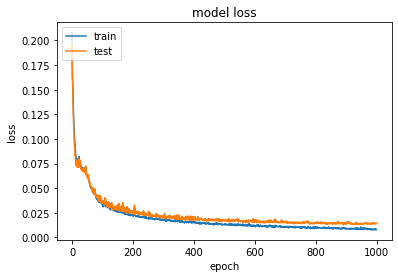

In [ ]:
history=model.fit(ax, ay, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(vx,vy))
impHistoria(history)

In [ ]:
score = model.evaluate(ax, ay, verbose=0); print('Training loss:', score)
score = model.evaluate(vx, vy, verbose=0); print('Validation loss:', score)
score = model.evaluate(qx, qy, verbose=0); print('Test loss:', score)
model.save('fcn-train1.h5')

Training loss: 0.0033260860946029425
Validation loss: 0.014462471008300781
Test loss: 0.015097904950380325


In [ ]:
batch_size = 20; epochs = 1000
umodel=unet()
opt=keras.optimizers.Adam()
umodel.compile(optimizer=opt, loss='mean_squared_error')

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_150 (Conv2D)            (None, 16, 16, 40)   1040        ['input_22[0][0]']               
                                                                                                  
 conv2d_151 (Conv2D)            (None, 8, 8, 12)     12012       ['conv2d_150[0][0]']             
                                                                                                  
 dropout_44 (Dropout)           (None, 8, 8, 12)     0           ['conv2d_151[0][0]']             
                                                                                           

dict_keys(['loss', 'val_loss'])


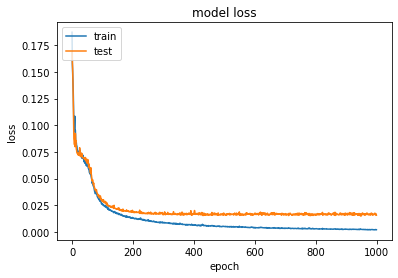

In [ ]:
history=umodel.fit(ax, ay, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(vx,vy))
impHistoria(history)

In [ ]:
score = umodel.evaluate(ax, ay, verbose=0); print('Training loss:', score)
score = umodel.evaluate(vx, vy, verbose=0); print('Validation loss:', score)
score = umodel.evaluate(qx, qy, verbose=0); print('Test loss:', score)
umodel.save('ucn-train1.h5')

Training loss: 0.0008064776775427163
Validation loss: 0.015573889948427677
Test loss: 0.013967785984277725
